In [2]:
# FACECOM Challenge - Final Submission Code

import os
import sys
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import random
from collections import defaultdict, Counter
import json
import pickle
from typing import Dict, List, Tuple, Optional, Union
import math

import cv2
from PIL import Image, ImageEnhance

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import _LRScheduler
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import timm

try:
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    ALBUMENTATIONS_AVAILABLE = True
except ImportError:
    ALBUMENTATIONS_AVAILABLE = False

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
import itertools
from tqdm.auto import tqdm

plt.style.use('default')
sns.set_palette("husl")

def clear_memory():
    import gc
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    gc.collect()


class OptimizedArcFaceConfig:
    """configuration"""

    # Dataset paths
    DATASET_PATH = "/kaggle/input/facecom/Comys_Hackathon5"
    TASK_A_TRAIN_PATH = os.path.join(DATASET_PATH, "Task_A/train")
    TASK_A_VAL_PATH = os.path.join(DATASET_PATH, "Task_A/val")
    TASK_B_TRAIN_PATH = os.path.join(DATASET_PATH, "Task_B/train")
    TASK_B_VAL_PATH = os.path.join(DATASET_PATH, "Task_B/val")

    # Model architecture
    IMG_SIZE = 224
    CHANNELS = 3
    BACKBONE = "convnext_tiny"
    PRETRAINED = True
    EMBEDDING_DIM = 512
    GENDER_CLASSES = 2

    # Batch and training
    BATCH_SIZE = 32
    GRADIENT_ACCUMULATION_STEPS = 2

    # Training phases
    NUM_EPOCHS_VERIFICATION = 40
    NUM_EPOCHS_GENDER = 15
    NUM_EPOCHS_JOINT = 8

    # Learning rates
    VERIFICATION_LR_BACKBONE = 1e-4
    VERIFICATION_LR_HEAD = 3e-4
    VERIFICATION_LR_ARCFACE = 3e-4
    GENDER_LR_HEAD = 5e-5
    JOINT_LR = 5e-6

    # Regularization
    VERIFICATION_DROPOUT = 0.4
    GENDER_DROPOUT = 0.5
    WEIGHT_DECAY = 1e-3
    LABEL_SMOOTHING = 0.1

    # ArcFace parameters
    ARCFACE_MARGIN = 0.5
    ARCFACE_SCALE = 64
    NUM_IDENTITIES = 500

    # Loss weights
    VERIFICATION_LOSS_WEIGHT = 1.0
    ARCFACE_LOSS_WEIGHT = 1.0
    GENDER_LOSS_WEIGHT = 1.0
    TRIPLET_LOSS_WEIGHT = 0.2

    # Hardware
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    NUM_WORKERS = 2
    PIN_MEMORY = True
    USE_AMP = True
    SEED = 42
    CHECKPOINT_DIR = "/kaggle/working/optimized_checkpoints"

    # Thresholds
    SIMILARITY_THRESHOLDS = np.arange(0.1, 0.95, 0.02)

    # Augmentation
    USE_ALBUMENTATIONS = True
    ROTATION_LIMIT = 15
    BRIGHTNESS_LIMIT = 0.15
    CONTRAST_LIMIT = 0.15
    PERSPECTIVE_PROB = 0.3
    ELASTIC_PROB = 0.2
    GAUSSIAN_NOISE_PROB = 0.3
    BLUR_PROB = 0.2

    # Advanced training
    PATIENCE = 15
    MIN_DELTA = 1e-4
    MAX_GRAD_NORM = 0.3
    CLEAR_CACHE_FREQUENCY = 5

    # Task B settings
    MAX_IDENTITIES_TRAIN = 500
    MAX_IDENTITIES_VAL = 200
    PAIRS_PER_IDENTITY = 25
    HARD_NEGATIVE_RATIO = 0.4

    # Temperature scaling
    USE_TEMPERATURE_SCALING = True
    INITIAL_TEMPERATURE = 1.5

    # Curriculum learning
    USE_CURRICULUM_LEARNING = True
    CURRICULUM_START_EPOCH = 10

    @classmethod
    def create_optimizers(cls, model):
        """optimizers"""
        verification_optimizer = torch.optim.AdamW([
            {'params': model.backbone.parameters(), 'lr': cls.VERIFICATION_LR_BACKBONE},
            {'params': model.verification_head.parameters(), 'lr': cls.VERIFICATION_LR_HEAD},
            {'params': model.arcface_loss.parameters(), 'lr': cls.VERIFICATION_LR_ARCFACE}
        ], weight_decay=cls.WEIGHT_DECAY, eps=1e-8)

        gender_optimizer = torch.optim.AdamW(
            model.gender_head.parameters(),
            lr=cls.GENDER_LR_HEAD,
            weight_decay=cls.WEIGHT_DECAY,
            eps=1e-8
        )

        joint_optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=cls.JOINT_LR,
            weight_decay=cls.WEIGHT_DECAY,
            eps=1e-8
        )

        return verification_optimizer, gender_optimizer, joint_optimizer

    @classmethod
    def create_schedulers(cls, optimizers, total_epochs):
        """learning rate schedulers"""
        verification_optimizer, gender_optimizer, joint_optimizer = optimizers

        verification_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            verification_optimizer,
            T_0=10,
            T_mult=2,
            eta_min=1e-7
        )

        gender_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            gender_optimizer,
            T_max=cls.NUM_EPOCHS_GENDER,
            eta_min=1e-8
        )

        joint_scheduler = torch.optim.lr_scheduler.ExponentialLR(
            joint_optimizer,
            gamma=0.95
        )

        return verification_scheduler, gender_scheduler, joint_scheduler


Starting data exploration...
Task A
Analyzing Training data at: /kaggle/input/facecom/Comys_Hackathon5/Task_A/train
Found 1532 male images
Found 394 female images
Training Data Summary:
  Male: 1532
  Female: 394
  Total: 1926
  Balance: 79.54% Male, 20.46% Female

Analyzing Validation data at: /kaggle/input/facecom/Comys_Hackathon5/Task_A/val
Found 317 male images
Found 105 female images
Validation Data Summary:
  Male: 317
  Female: 105
  Total: 422
  Balance: 75.12% Male, 24.88% Female



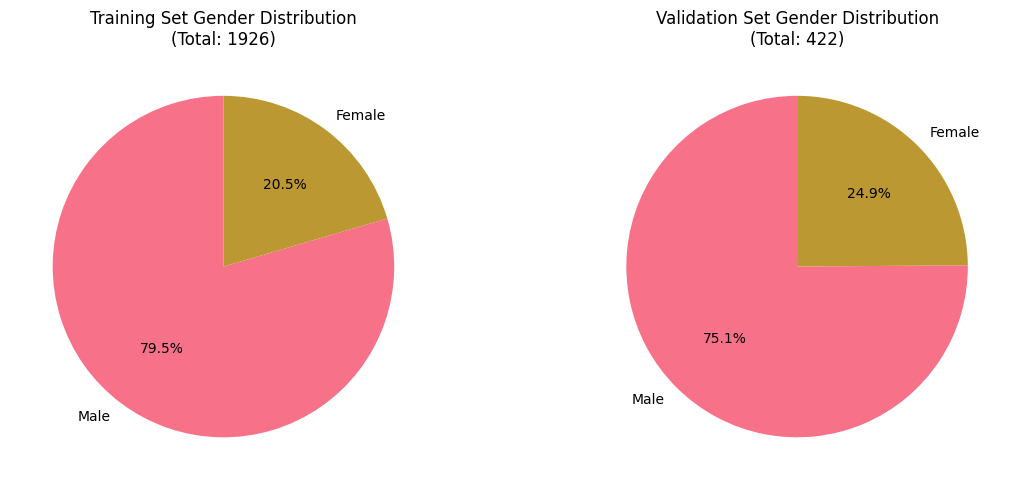

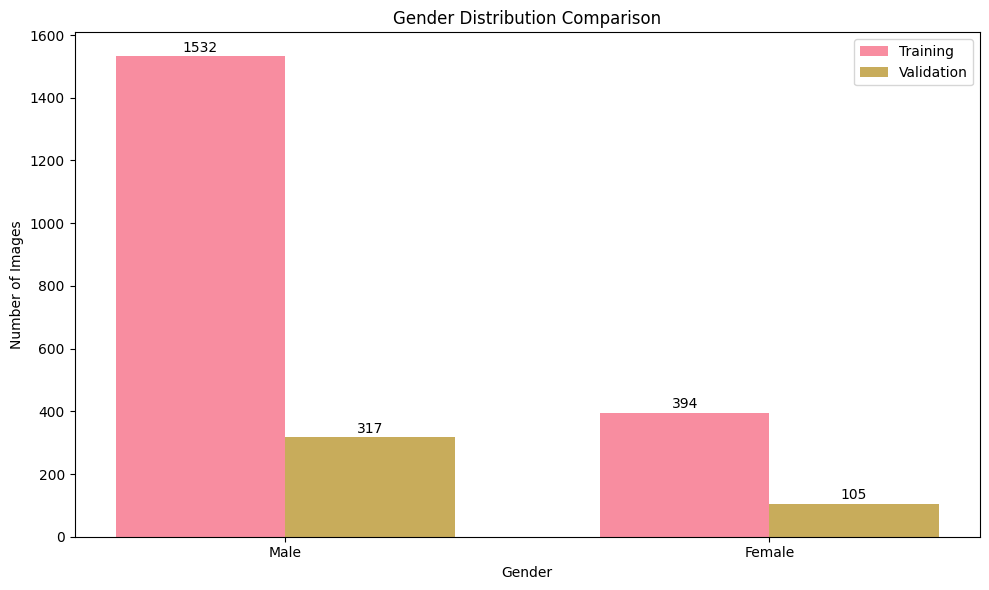

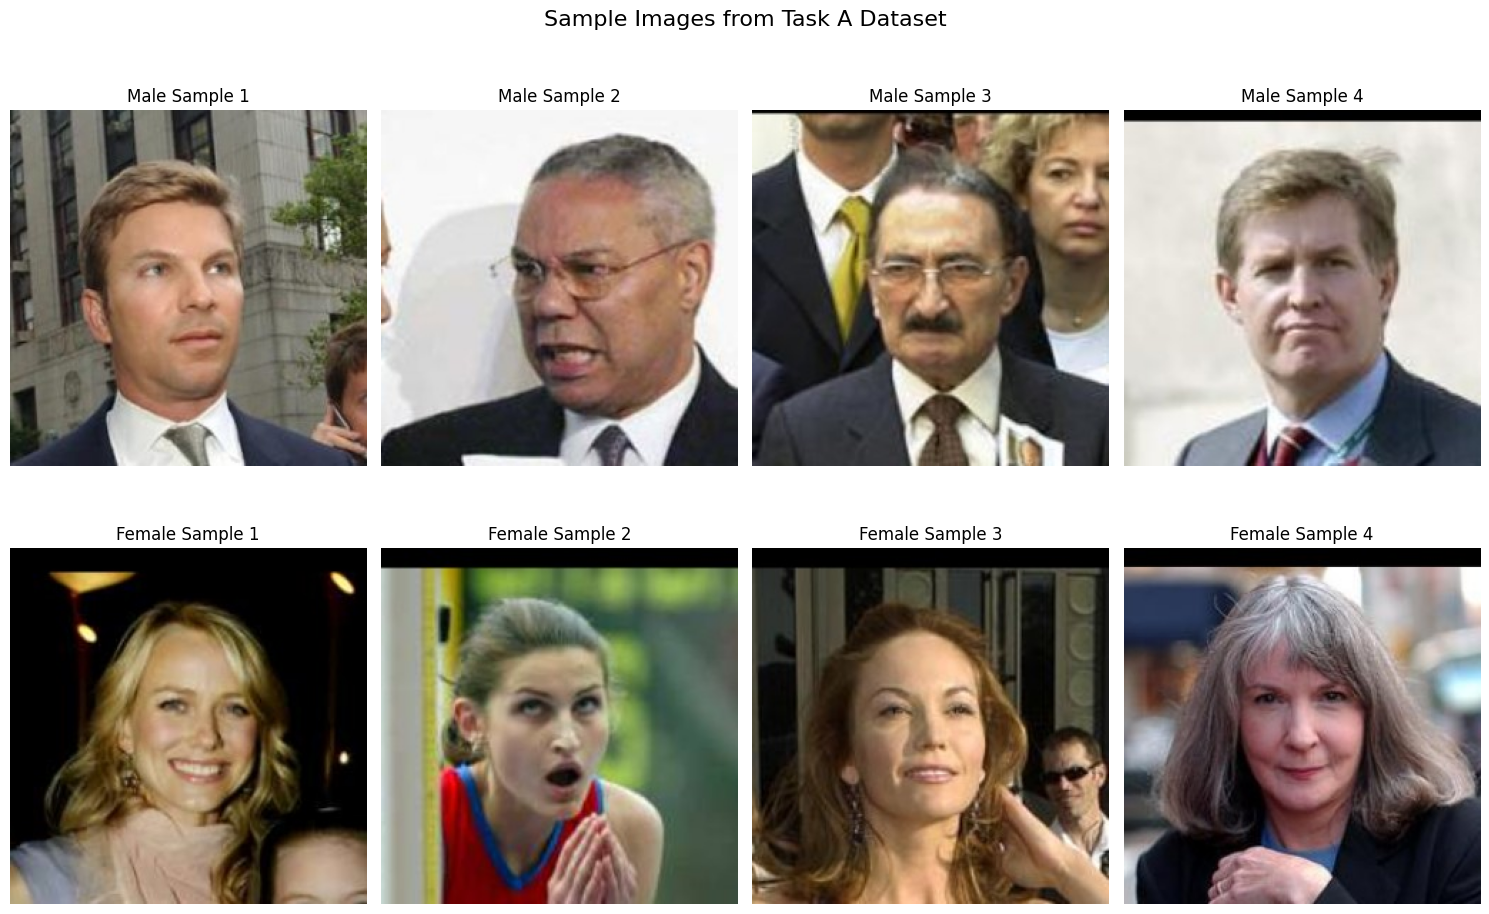


Starting Task B data exploration...
Task B
Analyzing Training data at: /kaggle/input/facecom/Comys_Hackathon5/Task_B/train
Found 877 identity folders
Training Data Summary:
  Total Identities: 877
  Original Images: 877
  Distorted Images: 6139
  Distortion Types: ['blurred', 'resized', 'noisy', 'foggy', 'sunny', 'rainy', 'lowlight']
    blurred: 877
    resized: 877
    noisy: 877
    foggy: 877
    sunny: 877
    rainy: 877
    lowlight: 877

Analyzing Validation data at: /kaggle/input/facecom/Comys_Hackathon5/Task_B/val
Found 250 identity folders
Validation Data Summary:
  Total Identities: 250
  Original Images: 250
  Distorted Images: 1750
  Distortion Types: ['foggy', 'lowlight', 'noisy', 'blurred', 'rainy', 'sunny', 'resized']
    foggy: 250
    lowlight: 250
    noisy: 250
    blurred: 250
    rainy: 250
    sunny: 250
    resized: 250



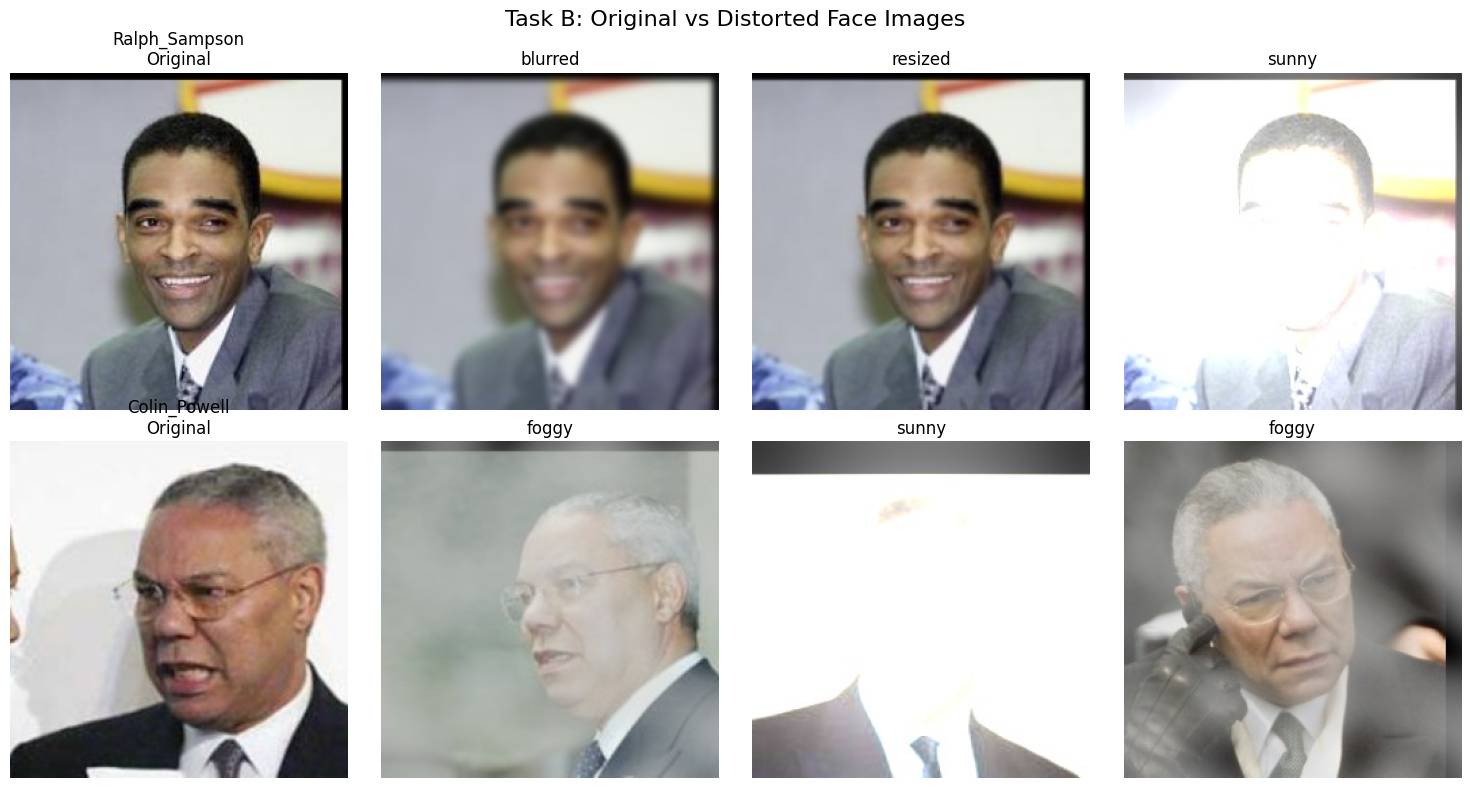

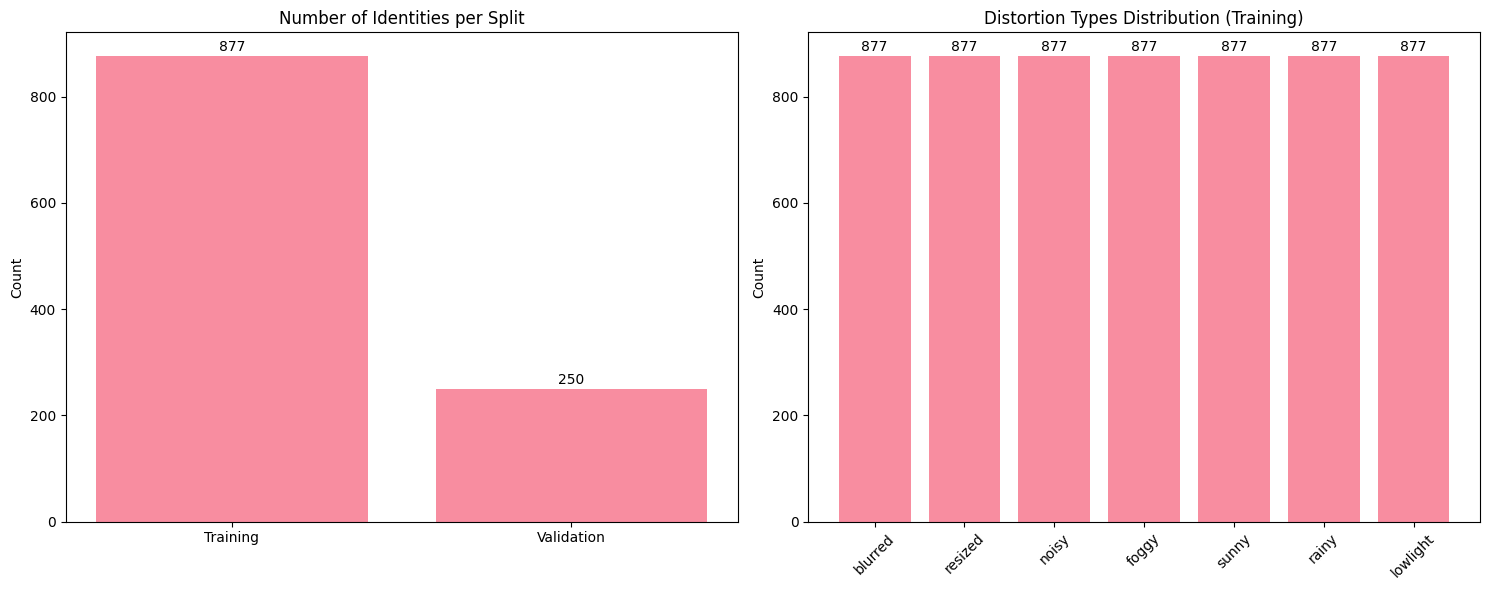


Transforms created successfully
Using Albumentations: True

Data exploration completed successfully


In [3]:
# Data Exploration and Preprocessing Pipeline

import matplotlib.gridspec as gridspec
from collections import Counter
import glob
import gc
import numpy as np

class DataExplorer:
    """Data exploration utilities"""
    def __init__(self, config):
        self.config = config
        self.task_a_stats = {}
        self.task_b_stats = {}

    def explore_task_a_data(self):
        """Task A dataset"""
        print("Task A")
        print("=" * 50)
        if not os.path.exists(self.config.DATASET_PATH):
            print(f"Dataset path not found: {self.config.DATASET_PATH}")
            return {'train': {'male': 0, 'female': 0, 'total': 0}, 'val': {'male': 0, 'female': 0, 'total': 0}}
        train_stats = self.analyze_gender_data(self.config.TASK_A_TRAIN_PATH, "Training")
        val_stats = self.analyze_gender_data(self.config.TASK_A_VAL_PATH, "Validation")
        self.task_a_stats = {'train': train_stats, 'val': val_stats}
        if train_stats['total'] > 0 or val_stats['total'] > 0:
            self.plot_gender_distribution()
            self.visualize_sample_images()
        else:
            print("No data found")
        return self.task_a_stats

    def analyze_gender_data(self, path, split_name):
        """Analyze gender classification data"""
        stats = {'male': 0, 'female': 0, 'total': 0}
        if not os.path.exists(path):
            print(f"{split_name} path not found: {path}")
            return stats
        print(f"Analyzing {split_name} data at: {path}")
        male_path = os.path.join(path, "male")
        if os.path.exists(male_path):
            male_files = [f for f in os.listdir(male_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
            stats['male'] = len(male_files)
            print(f"Found {stats['male']} male images")
        else:
            print(f"Male folder not found at: {male_path}")
        female_path = os.path.join(path, "female")
        if os.path.exists(female_path):
            female_files = [f for f in os.listdir(female_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
            stats['female'] = len(female_files)
            print(f"Found {stats['female']} female images")
        else:
            print(f"Female folder not found at: {female_path}")
        stats['total'] = stats['male'] + stats['female']
        print(f"{split_name} Data Summary:")
        print(f"  Male: {stats['male']}")
        print(f"  Female: {stats['female']}")
        print(f"  Total: {stats['total']}")
        if stats['total'] > 0:
            print(f"  Balance: {stats['male']/stats['total']:.2%} Male, {stats['female']/stats['total']:.2%} Female")
        print()
        return stats

    def explore_task_b_data(self):
        """Explore Task B"""
        print("Task B")
        print("=" * 50)
        if not os.path.exists(self.config.TASK_B_TRAIN_PATH):
            print(f"Task B training path not found: {self.config.TASK_B_TRAIN_PATH}")
            return
        train_stats = self.analyze_task_b_data(self.config.TASK_B_TRAIN_PATH, "Training")
        val_stats = self.analyze_task_b_data(self.config.TASK_B_VAL_PATH, "Validation")
        self.task_b_stats = {'train': train_stats, 'val': val_stats}
        if train_stats['total_identities'] > 0:
            self.visualize_task_b_samples()
            self.plot_task_b_distribution()
        return self.task_b_stats

    def analyze_task_b_data(self, path, split_name):
        """Analyze Task B"""
        stats = {
            'total_identities': 0,
            'total_original_images': 0,
            'total_distorted_images': 0,
            'distortion_types': {},
            'identity_folders': []
        }
        if not os.path.exists(path):
            print(f"{split_name} path not found: {path}")
            return stats
        print(f"Analyzing {split_name} data at: {path}")
        identity_folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
        identity_folders.sort()
        stats['total_identities'] = len(identity_folders)
        stats['identity_folders'] = identity_folders
        print(f"Found {stats['total_identities']} identity folders")
        sample_size = min(10, len(identity_folders))
        for identity_folder in identity_folders[:sample_size]:
            identity_path = os.path.join(path, identity_folder)
            original_images = [f for f in os.listdir(identity_path) 
                              if f.lower().endswith(('.jpg', '.jpeg')) and os.path.isfile(os.path.join(identity_path, f))]
            stats['total_original_images'] += len(original_images)
            distortion_path = os.path.join(identity_path, "distortion")
            if os.path.exists(distortion_path):
                distorted_images = [f for f in os.listdir(distortion_path) 
                                   if f.lower().endswith(('.jpg', '.jpeg'))]
                stats['total_distorted_images'] += len(distorted_images)
                for img_name in distorted_images:
                    if '_' in img_name:
                        parts = img_name.replace('.jpg', '').split('_')
                        if len(parts) >= 3:
                            distortion_type = parts[-1]
                            if distortion_type not in stats['distortion_types']:
                                stats['distortion_types'][distortion_type] = 0
                            stats['distortion_types'][distortion_type] += 1
        if len(identity_folders) > sample_size and sample_size > 0:
            extrapolation_factor = len(identity_folders) / sample_size
            stats['total_original_images'] = int(stats['total_original_images'] * extrapolation_factor)
            stats['total_distorted_images'] = int(stats['total_distorted_images'] * extrapolation_factor)
            for dist_type in stats['distortion_types']:
                stats['distortion_types'][dist_type] = int(stats['distortion_types'][dist_type] * extrapolation_factor)
        print(f"{split_name} Data Summary:")
        print(f"  Total Identities: {stats['total_identities']}")
        print(f"  Original Images: {stats['total_original_images']}")
        print(f"  Distorted Images: {stats['total_distorted_images']}")
        print(f"  Distortion Types: {list(stats['distortion_types'].keys())}")
        for dist_type, count in stats['distortion_types'].items():
            print(f"    {dist_type}: {count}")
        print()
        return stats

    def plot_gender_distribution(self):
        """Plot gender distribution across train/val splits"""
        train_total = self.task_a_stats['train']['total']
        val_total = self.task_a_stats['val']['total']
        if train_total == 0 and val_total == 0:
            print("No data available")
            return
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        if train_total > 0:
            train_data = [self.task_a_stats['train']['male'], self.task_a_stats['train']['female']]
            if any(x > 0 for x in train_data):
                axes[0].pie(train_data, labels=['Male', 'Female'], autopct='%1.1f%%', startangle=90)
                axes[0].set_title(f'Training Set Gender Distribution\n(Total: {train_total})')
            else:
                axes[0].text(0.5, 0.5, 'No training data', ha='center', va='center', transform=axes[0].transAxes)
                axes[0].set_title('Training Set - No Data')
        else:
            axes[0].text(0.5, 0.5, 'No training data', ha='center', va='center', transform=axes[0].transAxes)
            axes[0].set_title('Training Set - No Data')
        if val_total > 0:
            val_data = [self.task_a_stats['val']['male'], self.task_a_stats['val']['female']]
            if any(x > 0 for x in val_data):
                axes[1].pie(val_data, labels=['Male', 'Female'], autopct='%1.1f%%', startangle=90)
                axes[1].set_title(f'Validation Set Gender Distribution\n(Total: {val_total})')
            else:
                axes[1].text(0.5, 0.5, 'No validation data', ha='center', va='center', transform=axes[1].transAxes)
                axes[1].set_title('Validation Set - No Data')
        else:
            axes[1].text(0.5, 0.5, 'No validation data', ha='center', va='center', transform=axes[1].transAxes)
            axes[1].set_title('Validation Set - No Data')
        plt.tight_layout()
        plt.show()
        if train_total > 0 or val_total > 0:
            fig, ax = plt.subplots(figsize=(10, 6))
            x = np.arange(2)
            width = 0.35
            train_counts = [self.task_a_stats['train']['male'], self.task_a_stats['train']['female']]
            val_counts = [self.task_a_stats['val']['male'], self.task_a_stats['val']['female']]
            ax.bar(x - width/2, train_counts, width, label='Training', alpha=0.8)
            ax.bar(x + width/2, val_counts, width, label='Validation', alpha=0.8)
            ax.set_xlabel('Gender')
            ax.set_ylabel('Number of Images')
            ax.set_title('Gender Distribution Comparison')
            ax.set_xticks(x)
            ax.set_xticklabels(['Male', 'Female'])
            ax.legend()
            for i, (train_val, val_val) in enumerate(zip(train_counts, val_counts)):
                if train_val > 0:
                    ax.text(i - width/2, train_val + max(train_counts + val_counts) * 0.01, str(train_val), ha='center')
                if val_val > 0:
                    ax.text(i + width/2, val_val + max(train_counts + val_counts) * 0.01, str(val_val), ha='center')
            plt.tight_layout()
            plt.show()

    def visualize_sample_images(self):
        """Display sample images from each gender category"""
        fig = plt.figure(figsize=(15, 10))
        gs = gridspec.GridSpec(2, 4, figure=fig)
        samples_found = False
        male_train_path = os.path.join(self.config.TASK_A_TRAIN_PATH, "male")
        if os.path.exists(male_train_path):
            male_files = [f for f in os.listdir(male_train_path) if f.lower().endswith(('.jpg', '.jpeg'))]
            for i, filename in enumerate(male_files[:4]):
                try:
                    ax = fig.add_subplot(gs[0, i])
                    img_path = os.path.join(male_train_path, filename)
                    img = Image.open(img_path)
                    ax.imshow(img)
                    ax.set_title(f'Male Sample {i+1}')
                    ax.axis('off')
                    samples_found = True
                except Exception as e:
                    print(f"Error loading male image {filename}: {e}")
        female_train_path = os.path.join(self.config.TASK_A_TRAIN_PATH, "female")
        if os.path.exists(female_train_path):
            female_files = [f for f in os.listdir(female_train_path) if f.lower().endswith(('.jpg', '.jpeg'))]
            for i, filename in enumerate(female_files[:4]):
                try:
                    ax = fig.add_subplot(gs[1, i])
                    img_path = os.path.join(female_train_path, filename)
                    img = Image.open(img_path)
                    ax.imshow(img)
                    ax.set_title(f'Female Sample {i+1}')
                    ax.axis('off')
                    samples_found = True
                except Exception as e:
                    print(f"Error loading female image {filename}: {e}")
        if samples_found:
            plt.suptitle('Sample Images from Task A Dataset', fontsize=16)
            plt.tight_layout()
            plt.show()
        else:
            plt.close(fig)
            print("No sample images found")

    def visualize_task_b_samples(self):
        """Visualize samples from Task B"""
        if not os.path.exists(self.config.TASK_B_TRAIN_PATH):
            return
        identity_folders = [f for f in os.listdir(self.config.TASK_B_TRAIN_PATH) 
                           if os.path.isdir(os.path.join(self.config.TASK_B_TRAIN_PATH, f))][:2]
        if not identity_folders:
            print("No identity folders found for visualization")
            return
        fig = plt.figure(figsize=(15, 8))
        for idx, identity_folder in enumerate(identity_folders):
            identity_path = os.path.join(self.config.TASK_B_TRAIN_PATH, identity_folder)
            original_images = [f for f in os.listdir(identity_path) 
                              if f.lower().endswith(('.jpg', '.jpeg')) and os.path.isfile(os.path.join(identity_path, f))]
            if original_images:
                ax = plt.subplot(2, 4, idx * 4 + 1)
                original_path = os.path.join(identity_path, original_images[0])
                try:
                    img = Image.open(original_path)
                    ax.imshow(img)
                    ax.set_title(f'{identity_folder}\nOriginal')
                    ax.axis('off')
                except Exception as e:
                    print(f"Error loading {original_path}: {e}")
            distortion_path = os.path.join(identity_path, "distortion")
            if os.path.exists(distortion_path):
                distorted_images = [f for f in os.listdir(distortion_path) 
                                   if f.lower().endswith(('.jpg', '.jpeg'))][:3]
                for dist_idx, dist_img in enumerate(distorted_images):
                    ax = plt.subplot(2, 4, idx * 4 + 2 + dist_idx)
                    dist_path = os.path.join(distortion_path, dist_img)
                    try:
                        img = Image.open(dist_path)
                        ax.imshow(img)
                        dist_type = dist_img.replace('.jpg', '').split('_')[-1]
                        ax.set_title(f'{dist_type}')
                        ax.axis('off')
                    except Exception as e:
                        print(f"Error loading {dist_path}: {e}")
        plt.suptitle('Task B: Original vs Distorted Face Images', fontsize=16)
        plt.tight_layout()
        plt.show()

    def plot_task_b_distribution(self):
        """Plot Task B data distribution"""
        if not hasattr(self, 'task_b_stats') or not self.task_b_stats:
            return
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        train_identities = self.task_b_stats['train']['total_identities']
        val_identities = self.task_b_stats['val']['total_identities']
        axes[0].bar(['Training', 'Validation'], [train_identities, val_identities], alpha=0.8)
        axes[0].set_title('Number of Identities per Split')
        axes[0].set_ylabel('Count')
        axes[0].text(0, train_identities + max(train_identities, val_identities) * 0.01, 
                    str(train_identities), ha='center')
        axes[0].text(1, val_identities + max(train_identities, val_identities) * 0.01, 
                    str(val_identities), ha='center')
        distortion_types = self.task_b_stats['train']['distortion_types']
        if distortion_types:
            types = list(distortion_types.keys())
            counts = list(distortion_types.values())
            axes[1].bar(types, counts, alpha=0.8)
            axes[1].set_title('Distortion Types Distribution (Training)')
            axes[1].set_ylabel('Count')
            axes[1].tick_params(axis='x', rotation=45)
            for i, count in enumerate(counts):
                axes[1].text(i, count + max(counts) * 0.01, str(count), ha='center')
        plt.tight_layout()
        plt.show()

class DataTransforms:
    """Data transformation utilities for both tasks"""
    def __init__(self, config):
        self.config = config

    def get_task_a_transforms(self):
        """Get transforms for Task A"""
        if self.config.USE_ALBUMENTATIONS:
            train_transform = A.Compose([
                A.Resize(self.config.IMG_SIZE, self.config.IMG_SIZE),
                A.HorizontalFlip(p=0.5),
                A.Rotate(limit=self.config.ROTATION_LIMIT, p=0.5),
                A.RandomBrightnessContrast(
                    brightness_limit=self.config.BRIGHTNESS_LIMIT,
                    contrast_limit=self.config.CONTRAST_LIMIT,
                    p=0.5
                ),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])
            val_transform = A.Compose([
                A.Resize(self.config.IMG_SIZE, self.config.IMG_SIZE),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])
        else:
            train_transform = transforms.Compose([
                transforms.Resize((self.config.IMG_SIZE, self.config.IMG_SIZE)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(self.config.ROTATION_LIMIT),
                transforms.ColorJitter(
                    brightness=self.config.BRIGHTNESS_LIMIT,
                    contrast=self.config.CONTRAST_LIMIT
                ),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
            val_transform = transforms.Compose([
                transforms.Resize((self.config.IMG_SIZE, self.config.IMG_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        return train_transform, val_transform

    def get_task_b_transforms(self):
        """Get transforms for Task B"""
        if self.config.USE_ALBUMENTATIONS:
            train_transform = A.Compose([
                A.Resize(self.config.IMG_SIZE, self.config.IMG_SIZE),
                A.HorizontalFlip(p=0.5),
                A.Rotate(limit=15, p=0.5),
                A.RandomBrightnessContrast(
                    brightness_limit=0.2,
                    contrast_limit=0.2,
                    p=0.6
                ),
                A.GaussNoise(var_limit=(10.0, 30.0), p=0.2),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])
            val_transform = A.Compose([
                A.Resize(self.config.IMG_SIZE, self.config.IMG_SIZE),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])
        else:
            train_transform = transforms.Compose([
                transforms.Resize((self.config.IMG_SIZE, self.config.IMG_SIZE)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(15),
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
            val_transform = transforms.Compose([
                transforms.Resize((self.config.IMG_SIZE, self.config.IMG_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        return train_transform, val_transform

# Initialize data exploration and transforms
try:
    explorer = DataExplorer(OptimizedArcFaceConfig)
    transform_utils = DataTransforms(OptimizedArcFaceConfig)
    print("Starting data exploration...")
    task_a_stats = explorer.explore_task_a_data()
    print("\nStarting Task B data exploration...")
    task_b_stats = explorer.explore_task_b_data()
    task_a_train_transform, task_a_val_transform = transform_utils.get_task_a_transforms()
    task_b_train_transform, task_b_val_transform = transform_utils.get_task_b_transforms()
    print(f"\nTransforms created successfully")
    print(f"Using Albumentations: {OptimizedArcFaceConfig.USE_ALBUMENTATIONS}")
    print("\nData exploration completed successfully")
except Exception as e:
    print(f"Error during data exploration: {e}")
    print("Please verify dataset path and structure")


In [4]:
# Data Loading Pipeline for Final Submission

import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader

class TaskADataset(Dataset):
    """Dataset for Task A"""
    def __init__(self, root_dir, transform=None, split='train'):
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {'male': 0, 'female': 1}
        self._load_data()

    def _load_data(self):
        for class_name, class_idx in self.class_to_idx.items():
            class_dir = os.path.join(self.root_dir, class_name)
            if os.path.exists(class_dir):
                image_files = [f for f in os.listdir(class_dir)
                               if f.lower().endswith(('.jpg', '.jpeg'))]
                for image_file in image_files:
                    image_path = os.path.join(class_dir, image_file)
                    self.image_paths.append(image_path)
                    self.labels.append(class_idx)
        print(f"TaskA {self.split}: Loaded {len(self.image_paths)} images "
              f"(Male: {self.labels.count(0)}, Female: {self.labels.count(1)})")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        try:
            image = Image.open(image_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            image = Image.new('RGB', (OptimizedArcFaceConfig.IMG_SIZE, OptimizedArcFaceConfig.IMG_SIZE), (0, 0, 0))
        if self.transform:
            if OptimizedArcFaceConfig.USE_ALBUMENTATIONS:
                image = self.transform(image=np.array(image))['image']
            else:
                image = self.transform(image)
        return image, label

class TaskBDataset(Dataset):
    """Dataset for Task B"""
    def __init__(self, root_dir, transform=None, split='train'):
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        self.identity_data = {}
        self.pairs = []
        self.labels = []
        self.identity_labels = []
        self.identity_to_idx = {}
        self._load_identity_data()
        self._generate_pairs()

    def _load_identity_data(self):
        if not os.path.exists(self.root_dir):
            print(f"TaskB {self.split}: Root directory not found: {self.root_dir}")
            return
        identity_folders = [f for f in os.listdir(self.root_dir)
                            if os.path.isdir(os.path.join(self.root_dir, f))]
        max_identities = OptimizedArcFaceConfig.MAX_IDENTITIES_TRAIN if self.split == 'train' else OptimizedArcFaceConfig.MAX_IDENTITIES_VAL
        identity_folders = identity_folders[:max_identities]
        for idx, identity_folder in enumerate(identity_folders):
            self.identity_to_idx[identity_folder] = idx
        for identity_folder in identity_folders:
            identity_path = os.path.join(self.root_dir, identity_folder)
            original_images = [f for f in os.listdir(identity_path)
                               if f.lower().endswith(('.jpg', '.jpeg')) and
                               os.path.isfile(os.path.join(identity_path, f))]
            distorted_images = []
            distortion_path = os.path.join(identity_path, "distortion")
            if os.path.exists(distortion_path):
                distorted_images = [f for f in os.listdir(distortion_path)
                                   if f.lower().endswith(('.jpg', '.jpeg'))]
            all_images = [os.path.join(identity_path, img) for img in original_images]
            all_images += [os.path.join(distortion_path, img) for img in distorted_images]
            if len(all_images) >= 2:
                self.identity_data[identity_folder] = all_images
        print(f"TaskB {self.split}: Loaded {len(self.identity_data)} identities")

    def _generate_pairs(self):
        identities = list(self.identity_data.keys())
        if len(identities) < 2:
            return
        # Positive pairs
        for identity in identities:
            images = self.identity_data[identity]
            identity_idx = self.identity_to_idx[identity]
            pairs_generated = 0
            for i in range(len(images)):
                for j in range(i + 1, len(images)):
                    if pairs_generated < OptimizedArcFaceConfig.PAIRS_PER_IDENTITY:
                        self.pairs.append((images[i], images[j]))
                        self.labels.append(1)
                        self.identity_labels.append(identity_idx)
                        pairs_generated += 1
                    else:
                        break
                if pairs_generated >= OptimizedArcFaceConfig.PAIRS_PER_IDENTITY:
                    break
        # Negative pairs
        num_positive_pairs = self.labels.count(1)
        negative_pairs_generated = 0
        for i, identity1 in enumerate(identities):
            for j, identity2 in enumerate(identities[i + 1:], i + 1):
                if negative_pairs_generated >= num_positive_pairs:
                    break
                images1 = self.identity_data[identity1]
                images2 = self.identity_data[identity2]
                for img1 in images1:
                    for img2 in images2:
                        if negative_pairs_generated < num_positive_pairs:
                            self.pairs.append((img1, img2))
                            self.labels.append(0)
                            self.identity_labels.append(self.identity_to_idx[identity1])
                            negative_pairs_generated += 1
                        else:
                            break
                    if negative_pairs_generated >= num_positive_pairs:
                        break
            if negative_pairs_generated >= num_positive_pairs:
                break
        print(f"TaskB {self.split}: Generated {len(self.pairs)} pairs "
              f"(Positive: {self.labels.count(1)}, Negative: {self.labels.count(0)})")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img1_path, img2_path = self.pairs[idx]
        label = self.labels[idx]
        identity_label = self.identity_labels[idx]
        try:
            img1 = Image.open(img1_path).convert('RGB')
            img2 = Image.open(img2_path).convert('RGB')
        except Exception as e:
            img1 = Image.new('RGB', (OptimizedArcFaceConfig.IMG_SIZE, OptimizedArcFaceConfig.IMG_SIZE), (0, 0, 0))
            img2 = Image.new('RGB', (OptimizedArcFaceConfig.IMG_SIZE, OptimizedArcFaceConfig.IMG_SIZE), (0, 0, 0))
        if self.transform:
            if OptimizedArcFaceConfig.USE_ALBUMENTATIONS:
                img1 = self.transform(image=np.array(img1))['image']
                img2 = self.transform(image=np.array(img2))['image']
            else:
                img1 = self.transform(img1)
                img2 = self.transform(img2)
        return img1, img2, label, identity_label

def get_research_optimized_transforms():
    """Get transforms"""
    if OptimizedArcFaceConfig.USE_ALBUMENTATIONS:
        import albumentations as A
        from albumentations.pytorch import ToTensorV2
        train_transform = A.Compose([
            A.Resize(OptimizedArcFaceConfig.IMG_SIZE, OptimizedArcFaceConfig.IMG_SIZE),
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=OptimizedArcFaceConfig.ROTATION_LIMIT, p=0.5),
            A.Perspective(scale=(0.05, 0.1), p=OptimizedArcFaceConfig.PERSPECTIVE_PROB),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=OptimizedArcFaceConfig.ELASTIC_PROB),
            A.RandomBrightnessContrast(
                brightness_limit=OptimizedArcFaceConfig.BRIGHTNESS_LIMIT,
                contrast_limit=OptimizedArcFaceConfig.CONTRAST_LIMIT,
                p=0.6
            ),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.4),
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
            A.Blur(blur_limit=3, p=0.1),
            A.CLAHE(p=0.3),
            A.Sharpen(p=0.2),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
        val_transform = A.Compose([
            A.Resize(OptimizedArcFaceConfig.IMG_SIZE, OptimizedArcFaceConfig.IMG_SIZE),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
    else:
        import torchvision.transforms as transforms
        train_transform = transforms.Compose([
            transforms.Resize((OptimizedArcFaceConfig.IMG_SIZE, OptimizedArcFaceConfig.IMG_SIZE)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(OptimizedArcFaceConfig.ROTATION_LIMIT),
            transforms.ColorJitter(
                brightness=OptimizedArcFaceConfig.BRIGHTNESS_LIMIT,
                contrast=OptimizedArcFaceConfig.CONTRAST_LIMIT,
                saturation=0.2,
                hue=0.1
            ),
            transforms.RandomPerspective(distortion_scale=0.1, p=OptimizedArcFaceConfig.PERSPECTIVE_PROB),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        val_transform = transforms.Compose([
            transforms.Resize((OptimizedArcFaceConfig.IMG_SIZE, OptimizedArcFaceConfig.IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    return train_transform, val_transform

def create_final_data_loaders():
    """Create data loaders for final submission"""
    print("Creating data loaders...")
    train_transform, val_transform = get_research_optimized_transforms()
    task_a_train_dataset = TaskADataset(
        root_dir=OptimizedArcFaceConfig.TASK_A_TRAIN_PATH,
        transform=train_transform,
        split='train'
    )
    task_a_val_dataset = TaskADataset(
        root_dir=OptimizedArcFaceConfig.TASK_A_VAL_PATH,
        transform=val_transform,
        split='val'
    )
    task_b_train_dataset = TaskBDataset(
        root_dir=OptimizedArcFaceConfig.TASK_B_TRAIN_PATH,
        transform=train_transform,
        split='train'
    )
    task_b_val_dataset = TaskBDataset(
        root_dir=OptimizedArcFaceConfig.TASK_B_VAL_PATH,
        transform=val_transform,
        split='val'
    )
    task_a_train_loader = DataLoader(
        task_a_train_dataset,
        batch_size=OptimizedArcFaceConfig.BATCH_SIZE,
        shuffle=True,
        num_workers=OptimizedArcFaceConfig.NUM_WORKERS,
        pin_memory=OptimizedArcFaceConfig.PIN_MEMORY,
        drop_last=True
    )
    task_a_val_loader = DataLoader(
        task_a_val_dataset,
        batch_size=OptimizedArcFaceConfig.BATCH_SIZE,
        shuffle=False,
        num_workers=OptimizedArcFaceConfig.NUM_WORKERS,
        pin_memory=OptimizedArcFaceConfig.PIN_MEMORY
    )
    task_b_train_loader = DataLoader(
        task_b_train_dataset,
        batch_size=OptimizedArcFaceConfig.BATCH_SIZE,
        shuffle=True,
        num_workers=OptimizedArcFaceConfig.NUM_WORKERS,
        pin_memory=OptimizedArcFaceConfig.PIN_MEMORY,
        drop_last=True
    )
    task_b_val_loader = DataLoader(
        task_b_val_dataset,
        batch_size=OptimizedArcFaceConfig.BATCH_SIZE,
        shuffle=False,
        num_workers=OptimizedArcFaceConfig.NUM_WORKERS,
        pin_memory=OptimizedArcFaceConfig.PIN_MEMORY
    )
    return {
        'task_a': {
            'train_loader': task_a_train_loader,
            'val_loader': task_a_val_loader,
            'train_dataset': task_a_train_dataset,
            'val_dataset': task_a_val_dataset
        },
        'task_b': {
            'train_loader': task_b_train_loader,
            'val_loader': task_b_val_loader,
            'train_dataset': task_b_train_dataset,
            'val_dataset': task_b_val_dataset
        }
    }

class DataLoaderManager:
    """Manager class for handling data loading operations"""
    def __init__(self, config):
        self.config = config
        self.data_loaders = None

    def initialize_data_loaders(self):
        try:
            print("Initializing data loaders...")
            self.data_loaders = create_final_data_loaders()
            print("Data loaders created successfully!")
            self._verify_data_loaders()
            return True
        except Exception as e:
            print(f"Error creating data loaders: {e}")
            print("Please verify dataset paths and structure")
            return False

    def _verify_data_loaders(self):
        try:
            sample_batch = next(iter(self.data_loaders['task_a']['train_loader']))
            print(f"Task A batch shape: {sample_batch[0].shape}")
            sample_batch = next(iter(self.data_loaders['task_b']['train_loader']))
            print(f"Task B batch shapes: {sample_batch[0].shape}, {sample_batch[1].shape}")
            print("Data loader verification completed successfully")
        except Exception as e:
            print(f"Data loader verification failed: {e}")

    def get_data_loaders(self):
        if self.data_loaders is None:
            self.initialize_data_loaders()
        return self.data_loaders

# Initialize data loading system
print("Setting up data loading pipeline...")
data_manager = DataLoaderManager(OptimizedArcFaceConfig)
if data_manager.initialize_data_loaders():
    final_data_loaders = data_manager.get_data_loaders()
    print("Final data loading pipeline ready for training")
    print(f"Using Albumentations: {OptimizedArcFaceConfig.USE_ALBUMENTATIONS}")
    print("Data loaders optimized ")
else:
    print("Failed to initialize data loaders")
    final_data_loaders = None


Setting up data loading pipeline...
Initializing data loaders...
Creating data loaders...
TaskA train: Loaded 1926 images (Male: 1532, Female: 394)
TaskA val: Loaded 422 images (Male: 317, Female: 105)
TaskB train: Loaded 500 identities
TaskB train: Generated 25000 pairs (Positive: 12500, Negative: 12500)
TaskB val: Loaded 200 identities
TaskB val: Generated 10000 pairs (Positive: 5000, Negative: 5000)
Data loaders created successfully!
Task A batch shape: torch.Size([32, 3, 224, 224])
Task B batch shapes: torch.Size([32, 3, 224, 224]), torch.Size([32, 3, 224, 224])
Data loader verification completed successfully
Final data loading pipeline ready for training
Using Albumentations: True
Data loaders optimized 


In [6]:
# Model Architecture for Final Submission

import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import math

class ConvNeXtBackbone(nn.Module):
    """ConvNeXt backbone"""
    def __init__(self, model_name='convnext_tiny', pretrained=True, num_features=768):
        super().__init__()
        self.backbone = timm.create_model(
            model_name, 
            pretrained=pretrained,
            num_classes=0,
            global_pool=''
        )
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.num_features = num_features

    def forward(self, x):
        features = self.backbone(x)
        pooled = self.global_pool(features)
        flat = self.flatten(pooled)
        return flat

class ProvenGenderHead(nn.Module):
    """Gender classification head"""
    def __init__(self, input_features, num_classes=2, dropout_rate=0.5):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

class ArcFaceVerificationHead(nn.Module):
    """ArcFace embedding head"""
    def __init__(self, input_features, embedding_dim=512, dropout_rate=0.4):
        super().__init__()
        self.embedding_network = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, embedding_dim),
            nn.BatchNorm1d(embedding_dim)
        )

    def forward(self, x):
        emb = self.embedding_network(x)
        return F.normalize(emb, p=2, dim=1)

class ArcFaceLoss(nn.Module):
    """ArcFace loss"""
    def __init__(self, embedding_dim, num_classes, margin=0.5, scale=64):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        self.margin = margin
        self.scale = scale
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, embedding_dim))
        nn.init.xavier_uniform_(self.weight)
        self.cos_m = math.cos(margin)
        self.sin_m = math.sin(margin)
        self.th = math.cos(math.pi - margin)
        self.mm = math.sin(math.pi - margin) * margin

    def forward(self, embeddings, labels):
        embeddings = F.normalize(embeddings, p=2, dim=1)
        weight = F.normalize(self.weight, p=2, dim=1)
        cosine = F.linear(embeddings, weight)
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = torch.zeros_like(cosine, device=embeddings.device)
        one_hot.scatter_(1, labels.view(-1, 1).long(), 1)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.scale
        return output

class FinalHybridModel(nn.Module):
    """Final model: ConvNeXt backbone + Gender + ArcFace heads"""
    def __init__(self, config):
        super().__init__()
        self.backbone = ConvNeXtBackbone(
            model_name=config.BACKBONE,
            pretrained=config.PRETRAINED,
            num_features=768
        )
        self.gender_head = ProvenGenderHead(
            input_features=768,
            num_classes=config.GENDER_CLASSES,
            dropout_rate=config.GENDER_DROPOUT
        )
        self.verification_head = ArcFaceVerificationHead(
            input_features=768,
            embedding_dim=config.EMBEDDING_DIM,
            dropout_rate=config.VERIFICATION_DROPOUT
        )
        self.arcface_loss = ArcFaceLoss(
            embedding_dim=config.EMBEDDING_DIM,
            num_classes=config.NUM_IDENTITIES,
            margin=config.ARCFACE_MARGIN,
            scale=config.ARCFACE_SCALE
        )

    def forward(self, x, task='both'):
        shared_features = self.backbone(x)
        outputs = {}
        if task in ['gender', 'both']:
            outputs['gender'] = self.gender_head(shared_features)
        if task in ['embedding', 'both']:
            outputs['embedding'] = self.verification_head(shared_features)
        return outputs

    def arcface_forward(self, x, labels):
        emb = self.forward(x, task='embedding')['embedding']
        arcface_logits = self.arcface_loss(emb, labels)
        return arcface_logits, emb

class FinalCombinedLoss(nn.Module):
    """Combined loss for joint training"""
    def __init__(self, config):
        super().__init__()
        self.gender_loss = nn.CrossEntropyLoss(label_smoothing=config.LABEL_SMOOTHING)
        self.arcface_loss = nn.CrossEntropyLoss()
        self.verification_loss = nn.BCEWithLogitsLoss()
        self.gender_weight = config.GENDER_LOSS_WEIGHT
        self.arcface_weight = config.ARCFACE_LOSS_WEIGHT
        self.verification_weight = config.VERIFICATION_LOSS_WEIGHT

    def forward(self, outputs, targets):
        total_loss = 0.0
        loss_dict = {}
        if 'gender' in outputs and 'gender' in targets:
            gender_loss = self.gender_loss(outputs['gender'], targets['gender'])
            total_loss += self.gender_weight * gender_loss
            loss_dict['gender_loss'] = gender_loss.item()
        if 'arcface_logits' in outputs and 'identity' in targets:
            arcface_loss = self.arcface_loss(outputs['arcface_logits'], targets['identity'])
            total_loss += self.arcface_weight * arcface_loss
            loss_dict['arcface_loss'] = arcface_loss.item()
        if 'similarity' in outputs and 'verification' in targets:
            verification_loss = self.verification_loss(outputs['similarity'], targets['verification'].float())
            total_loss += self.verification_weight * verification_loss
            loss_dict['verification_loss'] = verification_loss.item()
        loss_dict['total_loss'] = total_loss.item()
        return total_loss, loss_dict

def create_final_model(config):
    """Create and initialize the final hybrid model"""
    print("Creating final hybrid model...")
    model = FinalHybridModel(config)
    model = model.to(config.DEVICE)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Final model created!")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print("Integrates gender and verification techniques")
    return model


In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tqdm.auto import tqdm
import numpy as np
import os

def train_and_validate(model, config, data_loaders):
    device = config.DEVICE
    model = model.to(device)
    loss_fn = FinalCombinedLoss(config)
    verification_optimizer, gender_optimizer, joint_optimizer = config.create_optimizers(model)
    verification_scheduler, gender_scheduler, joint_scheduler = config.create_schedulers(
        (verification_optimizer, gender_optimizer, joint_optimizer),
        total_epochs=max(config.NUM_EPOCHS_VERIFICATION, config.NUM_EPOCHS_GENDER, config.NUM_EPOCHS_JOINT)
    )
    scaler = torch.cuda.amp.GradScaler() if config.USE_AMP else None

    # ---- Phase 1: Gender Classification ----
    print("\nPHASE 1: Gender Classification Training")
    best_gender_acc = 0.0
    for epoch in range(config.NUM_EPOCHS_GENDER):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        all_train_preds, all_train_labels = [], []
        for images, labels in tqdm(data_loaders['task_a']['train_loader'], desc=f"Gender Train Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device)
            gender_optimizer.zero_grad()
            with torch.cuda.amp.autocast(enabled=config.USE_AMP):
                outputs = model(images, task='gender')
                loss = F.cross_entropy(outputs['gender'], labels, label_smoothing=config.LABEL_SMOOTHING)
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(gender_optimizer)
                scaler.update()
            else:
                loss.backward()
                gender_optimizer.step()
            running_loss += loss.item() * images.size(0)
            preds = outputs['gender'].argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())
        gender_scheduler.step()
        train_acc = correct / total
        train_loss = running_loss / total
        train_precision = precision_score(all_train_labels, all_train_preds, average='binary')
        train_recall = recall_score(all_train_labels, all_train_preds, average='binary')
        train_f1 = f1_score(all_train_labels, all_train_preds, average='binary')

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        all_val_preds, all_val_labels = [], []
        with torch.no_grad():
            for images, labels in data_loaders['task_a']['val_loader']:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images, task='gender')
                loss = F.cross_entropy(outputs['gender'], labels, label_smoothing=config.LABEL_SMOOTHING)
                val_loss += loss.item() * images.size(0)
                preds = outputs['gender'].argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())
        val_acc = val_correct / val_total
        val_loss = val_loss / val_total
        val_precision = precision_score(all_val_labels, all_val_preds, average='binary')
        val_recall = recall_score(all_val_labels, all_val_preds, average='binary')
        val_f1 = f1_score(all_val_labels, all_val_preds, average='binary')
        print(f"Epoch {epoch+1}:")
        print(f"  [Gender] Train Acc={train_acc:.4f} | Prec={train_precision:.4f} | Rec={train_recall:.4f} | F1={train_f1:.4f}")
        print(f"           Val   Acc={val_acc:.4f} | Prec={val_precision:.4f} | Rec={val_recall:.4f} | F1={val_f1:.4f}")

        if val_acc > best_gender_acc:
            best_gender_acc = val_acc
            torch.save(model.state_dict(), os.path.join(config.CHECKPOINT_DIR, 'best_gender.pth'))
            print(f"  New best gender model saved with val acc {val_acc:.4f}")

    # ---- Phase 2: ArcFace Verification ----
    print("\nPHASE 2: ArcFace Verification Training")
    best_verif_f1 = 0.0
    for param in model.gender_head.parameters():
        param.requires_grad = False  # Freeze gender head

    for epoch in range(config.NUM_EPOCHS_VERIFICATION):
        model.train()
        running_loss = 0.0
        sim_list, label_list = [], []
        for img1, img2, pair_labels, identity_labels in tqdm(data_loaders['task_b']['train_loader'], desc=f"ArcFace Train Epoch {epoch+1}"):
            img1, img2 = img1.to(device), img2.to(device)
            pair_labels, identity_labels = pair_labels.to(device), identity_labels.to(device)
            verification_optimizer.zero_grad()
            with torch.cuda.amp.autocast(enabled=config.USE_AMP):
                arcface_logits1, emb1 = model.arcface_forward(img1, identity_labels)
                _, emb2 = model.arcface_forward(img2, identity_labels)
                similarity = F.cosine_similarity(emb1, emb2, dim=1)
                outputs = {'arcface_logits': arcface_logits1, 'similarity': similarity}
                targets = {'identity': identity_labels, 'verification': pair_labels}
                loss, _ = loss_fn(outputs, targets)
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(verification_optimizer)
                scaler.update()
            else:
                loss.backward()
                verification_optimizer.step()
            running_loss += loss.item() * img1.size(0)
            sim_list.append(similarity.detach().cpu().numpy())
            label_list.append(pair_labels.detach().cpu().numpy())
        verification_scheduler.step()

        # Compute train metrics (using best F1 threshold)
        sim_array = np.concatenate(sim_list)
        label_array = np.concatenate(label_list)
        best_f1, best_thr = 0.0, 0.5
        for thr in config.SIMILARITY_THRESHOLDS:
            preds = (sim_array > thr).astype(int)
            f1 = f1_score(label_array, preds)
            if f1 > best_f1:
                best_f1, best_thr = f1, thr
        train_preds = (sim_array > best_thr).astype(int)
        train_precision = precision_score(label_array, train_preds)
        train_recall = recall_score(label_array, train_preds)
        train_acc = accuracy_score(label_array, train_preds)

        # Validation
        model.eval()
        val_sim, val_labels = [], []
        with torch.no_grad():
            for img1, img2, pair_labels, identity_labels in data_loaders['task_b']['val_loader']:
                img1, img2 = img1.to(device), img2.to(device)
                outputs1 = model(img1, task='embedding')['embedding']
                outputs2 = model(img2, task='embedding')['embedding']
                similarity = F.cosine_similarity(outputs1, outputs2, dim=1)
                val_sim.append(similarity.cpu().numpy())
                val_labels.append(pair_labels.numpy())
        val_sim = np.concatenate(val_sim)
        val_labels = np.concatenate(val_labels)
        best_val_f1, best_val_thr = 0.0, 0.5
        for thr in config.SIMILARITY_THRESHOLDS:
            preds = (val_sim > thr).astype(int)
            f1 = f1_score(val_labels, preds)
            if f1 > best_val_f1:
                best_val_f1, best_val_thr = f1, thr
        val_preds = (val_sim > best_val_thr).astype(int)
        val_precision = precision_score(val_labels, val_preds)
        val_recall = recall_score(val_labels, val_preds)
        val_acc = accuracy_score(val_labels, val_preds)
        print(f"Epoch {epoch+1}:")
        print(f"  [Verification] Train Acc={train_acc:.4f} | Prec={train_precision:.4f} | Rec={train_recall:.4f} | F1={best_f1:.4f}")
        print(f"                Val   Acc={val_acc:.4f} | Prec={val_precision:.4f} | Rec={val_recall:.4f} | F1={best_val_f1:.4f} @ thr={best_val_thr:.2f}")

        if best_val_f1 > best_verif_f1:
            best_verif_f1 = best_val_f1
            torch.save(model.state_dict(), os.path.join(config.CHECKPOINT_DIR, 'best_arcface.pth'))
            print(f"  New best verification model saved with val F1 {best_val_f1:.4f}")

    for param in model.gender_head.parameters():
        param.requires_grad = True  # Unfreeze for joint

    # ---- Phase 3: Joint Fine-tuning (Optional) ----
    print("\nPHASE 3: Joint Training")
    best_joint_score = 0.0
    for epoch in range(config.NUM_EPOCHS_JOINT):
        model.train()
        task_a_iter = iter(data_loaders['task_a']['train_loader'])
        task_b_iter = iter(data_loaders['task_b']['train_loader'])
        batch_count = 0
        while True:
            try:
                images, labels = next(task_a_iter)
                images, labels = images.to(device), labels.to(device)
                joint_optimizer.zero_grad()
                with torch.cuda.amp.autocast(enabled=config.USE_AMP):
                    outputs = model(images, task='gender')
                    targets = {'gender': labels}
                    loss, _ = loss_fn(outputs, targets)
                if scaler:
                    scaler.scale(loss).backward()
                    scaler.step(joint_optimizer)
                    scaler.update()
                else:
                    loss.backward()
                    joint_optimizer.step()
                batch_count += 1
            except StopIteration:
                break
            try:
                img1, img2, pair_labels, identity_labels = next(task_b_iter)
                img1, img2 = img1.to(device), img2.to(device)
                pair_labels, identity_labels = pair_labels.to(device), identity_labels.to(device)
                joint_optimizer.zero_grad()
                with torch.cuda.amp.autocast(enabled=config.USE_AMP):
                    arcface_logits1, emb1 = model.arcface_forward(img1, identity_labels)
                    _, emb2 = model.arcface_forward(img2, identity_labels)
                    similarity = F.cosine_similarity(emb1, emb2, dim=1)
                    outputs = {'arcface_logits': arcface_logits1, 'similarity': similarity}
                    targets = {'identity': identity_labels, 'verification': pair_labels}
                    loss, _ = loss_fn(outputs, targets)
                if scaler:
                    scaler.scale(loss).backward()
                    scaler.step(joint_optimizer)
                    scaler.update()
                else:
                    loss.backward()
                    joint_optimizer.step()
                batch_count += 1
            except StopIteration:
                break
        joint_scheduler.step()

        # Validation: Compute both gender and verification metrics
        model.eval()
        # Gender
        val_correct, val_total = 0, 0
        all_val_preds, all_val_labels = [], []
        with torch.no_grad():
            for images, labels in data_loaders['task_a']['val_loader']:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images, task='gender')
                preds = outputs['gender'].argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())
        gender_acc = val_correct / val_total
        gender_precision = precision_score(all_val_labels, all_val_preds, average='binary')
        gender_recall = recall_score(all_val_labels, all_val_preds, average='binary')
        gender_f1 = f1_score(all_val_labels, all_val_preds, average='binary')
        # Verification
        val_sim, val_labels = [], []
        with torch.no_grad():
            for img1, img2, pair_labels, identity_labels in data_loaders['task_b']['val_loader']:
                img1, img2 = img1.to(device), img2.to(device)
                outputs1 = model(img1, task='embedding')['embedding']
                outputs2 = model(img2, task='embedding')['embedding']
                similarity = F.cosine_similarity(outputs1, outputs2, dim=1)
                val_sim.append(similarity.cpu().numpy())
                val_labels.append(pair_labels.numpy())
        val_sim = np.concatenate(val_sim)
        val_labels = np.concatenate(val_labels)
        preds = (val_sim > best_thr).astype(int)
        verif_acc = accuracy_score(val_labels, preds)
        verif_precision = precision_score(val_labels, preds)
        verif_recall = recall_score(val_labels, preds)
        verif_f1 = f1_score(val_labels, preds)
        hackathon_score = 0.3 * gender_acc + 0.7 * verif_acc
        print(f"Epoch {epoch+1}:")
        print(f"  [Joint Gender]       Acc={gender_acc:.4f} | Prec={gender_precision:.4f} | Rec={gender_recall:.4f} | F1={gender_f1:.4f}")
        print(f"  [Joint Verification] Acc={verif_acc:.4f} | Prec={verif_precision:.4f} | Rec={verif_recall:.4f} | F1={verif_f1:.4f}")
        print(f"  Hackathon Score: {hackathon_score:.4f}")
        if hackathon_score > best_joint_score:
            best_joint_score = hackathon_score
            torch.save(model.state_dict(), os.path.join(config.CHECKPOINT_DIR, 'best_joint.pth'))
            print(f"  New best joint model saved with hackathon score {hackathon_score:.4f}")

    print(f"\nBest Gender Acc: {best_gender_acc:.4f}")
    print(f"Best Verification F1: {best_verif_f1:.4f}")
    print(f"Best Joint Hackathon Score: {best_joint_score:.4f}")

# Usage:
os.makedirs(OptimizedArcFaceConfig.CHECKPOINT_DIR, exist_ok=True)

Config = OptimizedArcFaceConfig 
model = create_final_model(Config)
train_and_validate(model, Config, final_data_loaders)


Creating final hybrid model...
Final model created!
Total parameters: 29,918,562
Trainable parameters: 29,918,562
Integrates gender and verification techniques

PHASE 3: Joint Training (Only)
Epoch 1:
  [Joint Gender]       Acc=0.6967 | Prec=0.4327 | Rec=0.7048 | F1=0.5362
  [Joint Verification] Acc=0.8646 | Prec=0.8799 | Rec=0.8444 | F1=0.8618
  Hackathon Score: 0.8142
  New best joint model saved with hackathon score 0.8142
